In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import (LinearRegression, Ridge, HuberRegressor, RANSACRegressor)
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from yellowbrick.regressor import ResidualsPlot
import statsmodels.stats.api as sms
from scipy import stats
from yellowbrick.regressor import PredictionError
from yellowbrick.features import RFECV
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz


# Análise Preditiva

Nessa parte do projeto buscamos fazer uma análise preditiva do preço dos carros seminovos a serem vendidos, baseados em suas features.

**Objetivo:** Prever o preço dos carros baseados em suas features.

# Preparação dos dados

In [2]:
df = pd.read_csv("C:/Users/SAMSUNG/OneDrive/Documentos/GitHub/vendas_carros/dados/df_clean.csv")

In [3]:
df = df.drop(columns=['region'])


Na fase da preparação dos dados utilizaremos pipelines para:
1. Separar a variável target do resto do dataset
2. Separar os dados entre treino e teste
3. Lidar com as variáveis categóricas através de one hot encoding e hash encoding
4. Normalizar os dados

In [4]:
#funções de ajuda
def get_value_count(data):
    categories = data.value_counts(normalize=True) * 100
    return categories

def num_unique(data):
    unique = data.nunique()
    return unique

In [5]:
colunas_object = df.select_dtypes(include='object').columns
for coluna in colunas_object:
    resultado = num_unique(df[coluna])
    print(f"A  coluna {coluna} tem {resultado} categorias unicas")

A  coluna manufacturer tem 41 categorias unicas
A  coluna model tem 20812 categorias unicas
A  coluna condition tem 6 categorias unicas
A  coluna cylinders tem 8 categorias unicas
A  coluna fuel tem 5 categorias unicas
A  coluna title_status tem 6 categorias unicas
A  coluna transmission tem 3 categorias unicas
A  coluna drive tem 3 categorias unicas
A  coluna type tem 13 categorias unicas
A  coluna paint_color tem 12 categorias unicas
A  coluna state tem 51 categorias unicas


In [6]:
get_value_count(df['model']).head(30)

f-150               1.911212
silverado 1500      1.204437
1500                1.024515
camry               0.762071
silverado           0.744668
accord              0.731476
civic               0.694425
escape              0.681233
2500                0.671970
wrangler            0.665514
altima              0.654567
tacoma              0.633235
explorer            0.605166
grand cherokee      0.596184
mustang             0.535274
corolla             0.534432
equinox             0.469593
cr-v                0.465944
focus               0.441524
fusion              0.440963
corvette            0.430296
malibu              0.421034
rav4                0.412894
tahoe               0.402508
grand caravan       0.400263
outback             0.396894
sonata              0.395491
impala              0.391842
odyssey             0.391842
silverado 2500hd    0.383983
Name: model, dtype: float64

Em relação as variáveis categóricas, trataremos com one hot encode.No One hot encoding, para cada nível categórico, criamos uma nova variável binária 0 ou 1. Como o modelo base será uma regressão linear, eliminaremos uma das dummies para evitar problemas de multicolineariedade perfeita.
Para as variáveis manufacturer e state irei diminuir as categorias de maneira similar ao que fiz na análise econométrica. Preferi eliminar a variável model por ela possuir mais de 2000 categorias únicas.

Irei utilizar o MinMaxScaler para normalizar os dados. Como pretendo trabalhar com algumas regressões que utilizam penalização (LASSO e Ridge), realizarei a normalização em todas as colunas.

In [7]:
df = df.drop(columns=['model'])

#categorizando estados por macro região
estados_nordeste = ['me', 'nh','vt','ma', 'ri', 'ct', 'ny', 'pa', 'nj']
nordeste = 'nordeste'

estados_centro_oeste = ['wi', 'mi', 'il', 'in', 'oh', 'mo', 'sd', 'nd', 'ne', 'ks', 'mn', 'ia']
centro_oeste = 'centro oeste'

estados_sul = ['de', 'md', 'va', 'wv', 'nc', 'sc', 'ga', 'fl', 'ky', 'tn', 'ms', 'al', 'ok', 'tx', 'ar', 'la', 'dc']
sul  = 'sul'

estados_oeste = ['id', 'mt', 'wy', 'nv', 'ut', 'co', 'az', 'nm', 'ca', 'or', 'wa', 'ak', 'hi']
oeste = 'oeste'

df['state'] = df['state'].replace(estados_nordeste, nordeste)
df['state'] = df['state'].replace(estados_centro_oeste, centro_oeste)
df['state'] = df['state'].replace(estados_sul, sul)
df['state'] = df['state'].replace(estados_oeste, oeste )

#categorizando manufacturer
carros = ['volvo', 'mitsubishi', 'mini', 'pontiac', 'jaguar', 'rover', 'porsche', 'saturn', 'mercury', 'alfa-romeo', 'tesla', 'fiat', 'harley-davidson', 'datsun', 'ferrari', 'aston-martin', 'land rover']
others = 'others'
df['manufacturer'] = df['manufacturer'].replace(carros, others)

In [8]:
#separando a variável target 
y = df.loc[:, 'price']
X = df.drop('price', axis=1)

In [9]:
# separando em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [10]:
# Separando as variáveis que receberão one hot encoding e as que receberão normalização
onehot_cols = ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'manufacturer', 'state']
normalization_cols = ['year', 'odometer']

# Definindo as etapas do pipeline
steps = Pipeline([
    ('preprocess', ColumnTransformer([
        ('onehot', OneHotEncoder(drop='first', sparse=False), onehot_cols),
        ('normalize', MinMaxScaler(), normalization_cols),
    ], remainder='passthrough')),
])


# Aplicando o pipeline aos dados de treinamento
x_train_preprocessed = steps.fit_transform(x_train)
# Aplicando o pipeline aos dados de teste
x_test_preprocessed = steps.transform(x_test)

#Criando datasets com os dados transformados
## obtendo o nome das colunas
original_columns = list(steps.named_steps['preprocess'].named_transformers_['onehot'].get_feature_names_out(onehot_cols)) + normalization_cols

#fazendo os dataset
x_train_preprocessed_df = pd.DataFrame(x_train_preprocessed, columns=original_columns)
x_test_preprocessed_df = pd.DataFrame(x_test_preprocessed, columns = original_columns)

# Normalizing the target variable y
y_scaler = MinMaxScaler()
y_train_preprocessed = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_preprocessed = y_scaler.transform(y_test.values.reshape(-1, 1))


In [20]:
x_train_preprocessed

array([[0.        , 0.        , 0.        , ..., 0.        , 0.88709677,
        0.09039773],
       [0.        , 1.        , 0.        , ..., 1.        , 0.72580645,
        0.28318571],
       [0.        , 1.        , 0.        , ..., 1.        , 0.70967742,
        0.50336626],
       ...,
       [0.        , 1.        , 0.        , ..., 0.        , 0.91935484,
        0.29974825],
       [1.        , 0.        , 0.        , ..., 1.        , 0.87096774,
        0.46999867],
       [0.        , 1.        , 0.        , ..., 0.        , 0.88709677,
        0.0417501 ]])

In [45]:
y_train_preprocessed

array([[0.25752184],
       [0.06020147],
       [0.0434454 ],
       ...,
       [0.17856426],
       [0.17592209],
       [0.19726016]])

In [52]:
y_train_preprocessed = y_train_preprocessed.reshape(-1)
y_test_preprocessed = y_test_preprocessed.reshape(-1)

In [12]:
y_train_preprocessed

array([0.25752184, 0.06020147, 0.0434454 , ..., 0.17856426, 0.17592209,
       0.19726016])

# Modelo machine learning

Nos modelos de machine learning, eu dividirei entre regressões e modelos de árvore. Como vimos na análise econométrica e na análise exploratória de dados, este dataset apresenta heterocedasticidade nos resíduos, alguns outliers e sua distribuição não é normal. Esses componentes são violações de hipóteses do modelo de regressão clássico. Essas violaçãoes podem levar o modelo a ficar viesado, resultando em um desempenho preditivo pior. Afinal, com a presença de outliers nos dados ou quando a variável resposta não segue uma distribuição normal, as estimativas resultantes podem não ser mais confiáveis.

A solução, portanto, é usar versões modificadas da regressão linear que abordem especificamente a expectativa de outliers no conjunto de dados, sendo as regressões robustas as mais adequadas para esses casos. Em regressões usaremos a OLS não robusta como baseline, a regressão Ridge, a regressão de Huber e a RANSAC. Também usaremos os modelos de SVM, Random Tree e XGBoost.

- **Regressão Ridge**:

- **Regressão de Huber**: um exemplo de algoritmo de regressão robusta que atribui menos peso às observações identificadas como outliers.

- **RANSAC**: RANSAC (Random Sample Consensus) é um algoritmo não determinístico que tenta separar os dados de treinamento em inliers (que podem estar sujeitos a ruído) e outliers. Em seguida, estima o modelo final usando apenas os inliers.

- **Random Forest**: é um algoritmo de aprendizado de máquina que combina várias árvores de decisão independentes e faz previsões tomando uma média ou votação das previsões individuais das árvores, resultando em um modelo mais robusto e com menor tendência ao overfitting.

- **XGBoost**: XGBoost é um algoritmo de boosting de gradiente extremamente poderoso e eficiente, que utiliza árvores de decisão como estimadores fracos e realiza treinamento iterativo para melhorar o desempenho preditivo em problemas de regressão e classificação.

Para melhorar a previsão do modelo e evitar overfitting, utilizarei cross validation com 5 k-folds. Feito isso, iremos avaliar os modelos através de algumas métricas. As métricas serão os R-quadrado, o MAE, RMSE e o MAD.

- **R-quadrado**: O R-quadrado é uma métrica que mede a proporção da variância total dos dados explicada pelo modelo de regressão, indicando o quão bem as variáveis independentes explicam a variabilidade da variável dependente.
- **MAE**: O MAE é uma métrica que calcula a média dos valores absolutos dos erros entre as previsões do modelo e os valores reais, fornecendo uma medida direta do tamanho médio dos erros de previsão.
- **RMSE**(Raiz do Erro Quadrático Médio): O RMSE é uma métrica usada para avaliar a precisão de modelos de regressão, que calcula a raiz quadrada da média dos quadrados das diferenças entre os valores previstos e os valores reais.
- **MAD** (Erro Absoluto Medio): é uma métrica que calcula a media dos valores absolutos dos erros entre as previsões do modelo e os valores reais, proporcionando uma medida robusta e menos sensível a outliers do tamanho médio dos erros de previsão.


In [13]:
def cross_validation(model, X, y):
    # Scikit-learn K-Fold
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)
    
    fold_r2 = []
    fold_MAE= []
    fold_RMSE = []
    fold_MAD =[]
    
    
    for idx, (idx_train, idx_validation) in enumerate(kfold.split(X,y)):
        X_train_split = X[idx_train, :]
        y_train_split = y[idx_train]
        
        model.fit(X_train_split, y_train_split)

        X_validation_split = X[idx_validation, :]
        y_validation_split = y[idx_validation]

        predictions = model.predict(X_validation_split)
        
        r2 = r2_score(y_validation_split, predictions)
        MAE = mean_absolute_error(y_validation_split, predictions)
        RMSE = np.sqrt(mean_squared_error(y_validation_split, predictions))
        MAD =  np.mean(np.abs(y_validation_split - predictions))
        
        fold_r2.append(r2)
        fold_MAE.append(MAE)
        fold_RMSE.append(RMSE)
        fold_MAD.append(MAD)
        
    print(f'Média geral do R2: {np.mean(fold_r2)}')
    print(f'Média geral da MAE: {np.mean(fold_MAE)}')
    print(f'Média geral do RMSE: {np.mean(fold_RMSE)}')
    print(f'Média geral da MAD: {np.mean(fold_MAD)}')    
    
    return fold_r2, fold_MAE, fold_RMSE, fold_MAD

In [19]:
models = [LinearRegression(),  Ridge(alpha=0.1),  HuberRegressor(max_iter=350), RANSACRegressor(random_state=42), RandomForestRegressor(),xgb.XGBRegressor()]


for model in models:
    print(f'Cross-validation for {type(model).__name__}:')
    cross_validation(model,x_train_preprocessed, y_train_preprocessed)
    print('------------------------------------------------------------')

Cross-validation for LinearRegression:
Média geral do R2: 0.6179628388509528
Média geral da MAE: 0.040004748655643234
Média geral do RMSE: 0.059722130570298584
Média geral da MAD: 0.040004748655643234
------------------------------------------------------------
Cross-validation for Ridge:
Média geral do R2: 0.6179628687511066
Média geral da MAE: 0.0400047315419372
Média geral do RMSE: 0.05972212832872299
Média geral da MAD: 0.0400047315419372
------------------------------------------------------------
Cross-validation for HuberRegressor:
Média geral do R2: 0.6050541875235333
Média geral da MAE: 0.03900465222222114
Média geral do RMSE: 0.06072340070641687
Média geral da MAD: 0.03900465222222114
------------------------------------------------------------
Cross-validation for RANSACRegressor:
Média geral do R2: -2.2858997956607273e+20
Média geral da MAE: 161467903.64023316
Média geral do RMSE: 951445300.9142879
Média geral da MAD: 161467903.64023316
-------------------------------------

In [46]:
dados = [
    {"Modelo": "LinearRegression", "R2": 0.6179628388509528, "MAE": 0.040004748655643234, "RMSE": 0.059722130570298584, "MAD": 0.040004748655643234},
    {"Modelo": "Ridge", "R2": 0.6179628687511066, "MAE": 0.0400047315419372, "RMSE": 0.05972212832872299, "MAD": 0.0400047315419372},
    {"Modelo": "HuberRegressor", "R2": 0.6050541875235333, "MAE": 0.03900465222222114, "RMSE": 0.06072340070641687, "MAD": 0.03900465222222114},
    {"Modelo": "RANSACRegressor", "R2": -2.2858997956607273e+20, "MAE": 161467903.64023316, "RMSE": 951445300.9142879, "MAD": 161467903.64023316},
    {"Modelo": "RandomForestRegressor", "R2": 0.8634362967153096, "MAE": 0.016657201209182453, "RMSE": 0.035704024575044166, "MAD": 0.016657201209182453},
    {"Modelo": "XGBRegressor", "R2": 0.8009899991152809, "MAE": 0.026083716193812702, "RMSE": 0.04310273654449514, "MAD": 0.026083716193812702}
]

avaliacao = pd.DataFrame(dados)
pd.options.display.float_format = '{:.3f}'.format

In [47]:
avaliacao

,Modelo,R2,MAE,RMSE,MAD
0,LinearRegression,0.618,0.040,0.060,0.040
1,Ridge,0.618,0.040,0.060,0.040
2,HuberRegressor,0.605,0.039,0.061,0.039
3,RANSACRegressor,-228589979566072725504.000,161467903.640,951445300.914,161467903.640
4,RandomForestRegressor,0.863,0.017,0.036,0.017
5,XGBRegressor,0.801,0.026,0.043,0.026


- Os modelos LinearRegression e Ridge apresentam resultados semelhantes em todas as métricas, com R-2 de aproximadamente 0.618, MAE de aproximadamente 0.040, RMSE de aproximadamente 0.060 e MAD de aproximadamente 0.040. Isso ocorre porque Ridge é uma forma de regularização aplicada à regressão linear. Portanto, os resultados são quase idênticos.
- O modelo de HuberRegressor tem desempenho pior no R2, o que não é surpreendente visto que ele é robusto aos problemas que existem no dataset e que levam a resultados viesados. Ele explica 60% da variação. Seus resultados de MAE e MAD são ligeiramente melhores. Quanto mais perto de 0 o MAE estiver melhor seu resultado. Aqui temos que, em média, as previsões do modelo têm um desvio absoluto médio de aproximadamente 0.039 unidades em relação aos valores reais. O RMSE segue lógica simmilar. O MAD calcula o quão disperso os dados são e o quão distante eles estão, em média, da média. Um valor baixo de MAD siginifica que os dados estão agrupados ao redor da média, indicando um modelo mais confiável e estável.
- O modelo de RANSACRegressor apresenta resultados horríveis, incluindo um R2 negativo. Ele provavelmente esta mal específicado.
- Os modelos de árvore tem resultados melhores, aumentando significativamente o R2 (saindo de 60% nos modelos de regressão para 80% nos modelos de árvore). O MAE, RMSE e MAD também ficam mais próximos de zero. 
- Desses modelos, o RandomForestRegressor tem o melhor desempenho, tanto com o maior valor do R2 quanto com os menores valores de MAE, RMSE e MAD.


## Análise de Resíduos

Para  o RandomForestRegressor eu vou analisar seus resíduos.

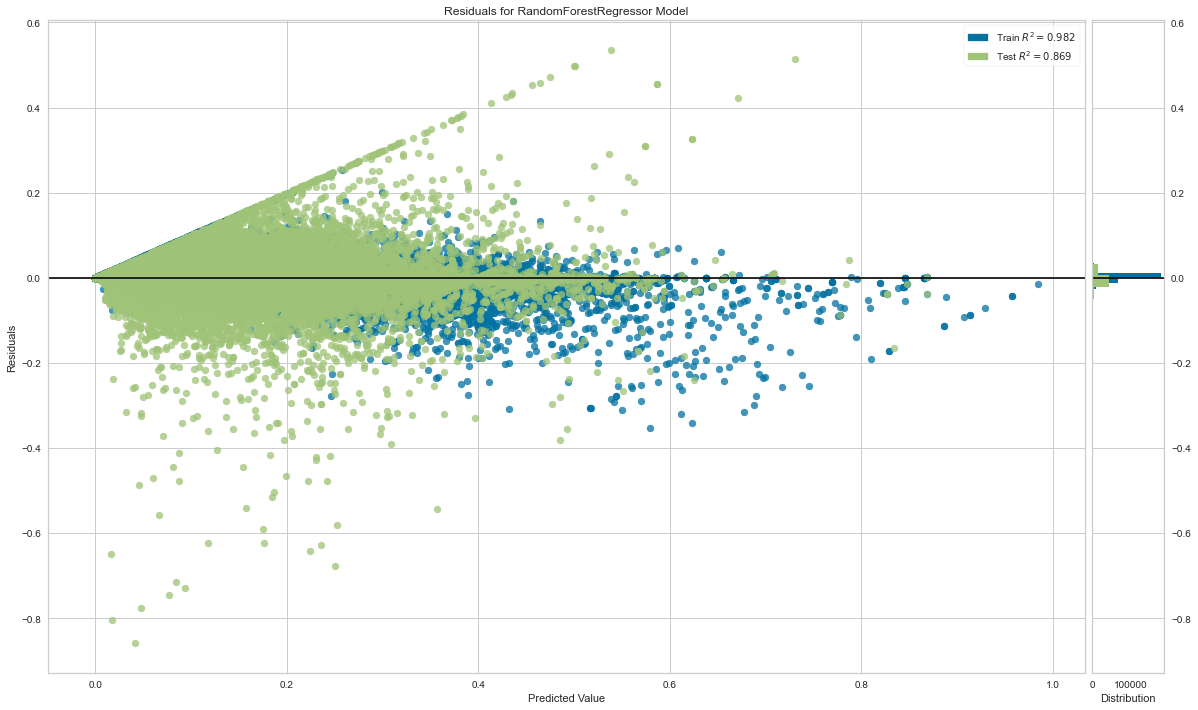

In [61]:

fig, ax = plt.subplots(figsize=(16,10))
rpv = ResidualsPlot(RandomForestRegressor())
rpv.fit(x_train_preprocessed, y_train_preprocessed)
rpv.score(x_test_preprocessed, y_test_preprocessed)
rpv.poof()
plt.show()


In [62]:
model = RandomForestRegressor()
model.fit(x_train_preprocessed, y_train_preprocessed)
y_pred = model.predict(x_test_preprocessed)
resids = y_test_preprocessed - y_pred

hb = sms.het_breuschpagan(resids, x_test_preprocessed)
labels = [
    'Lagrange multiplier statistic',
    'p-value',
    'f-value',
    'f p-value'
]

for name, num in zip(labels, hb):
    print(f'{name}: {num:.2}')

Lagrange multiplier statistic: 2.5e+03
p-value: 0.0
f-value: 3.3e+01
f p-value: 0.0


O valor p é usado para determinar a significância estatística do teste. Neste caso, o valor p é 0.0, o que está abaixo do limite típico de 0.05. Portanto, podemos rejeitar a hipótese nula de homocedasticidade e concluir que há evidências de heterocedasticidade nos resíduos.

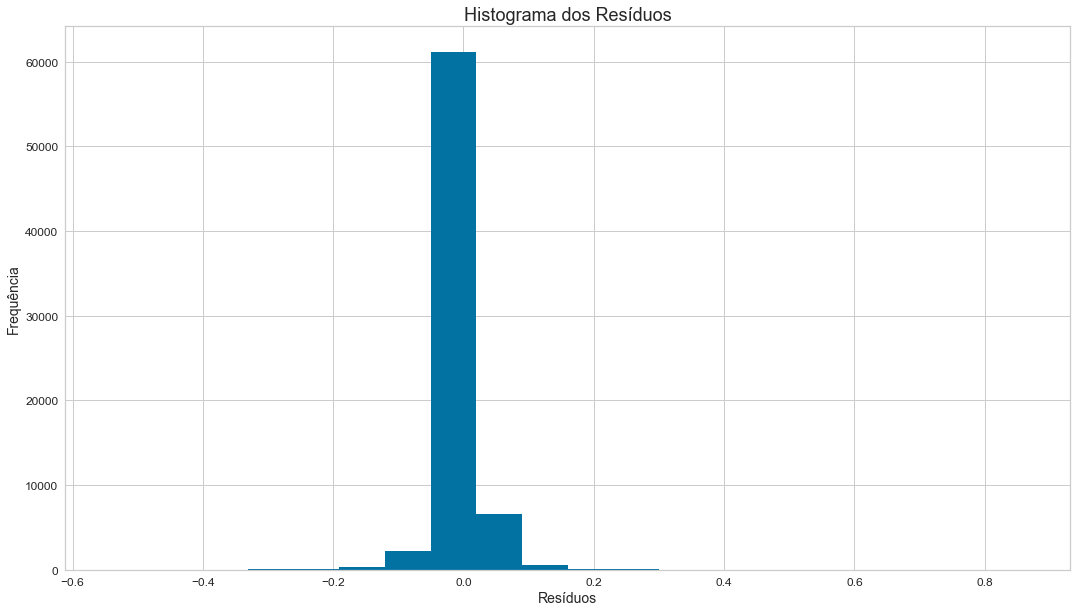

In [79]:
fig, ax = plt.subplots(figsize=(18,10))
resids = y_test_preprocessed - y_pred
pd.Series(resids, name='residuals').plot.hist(bins=20, ax=ax)
plt.title('Histograma dos Resíduos', fontsize=18)
plt.xlabel('Resíduos', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

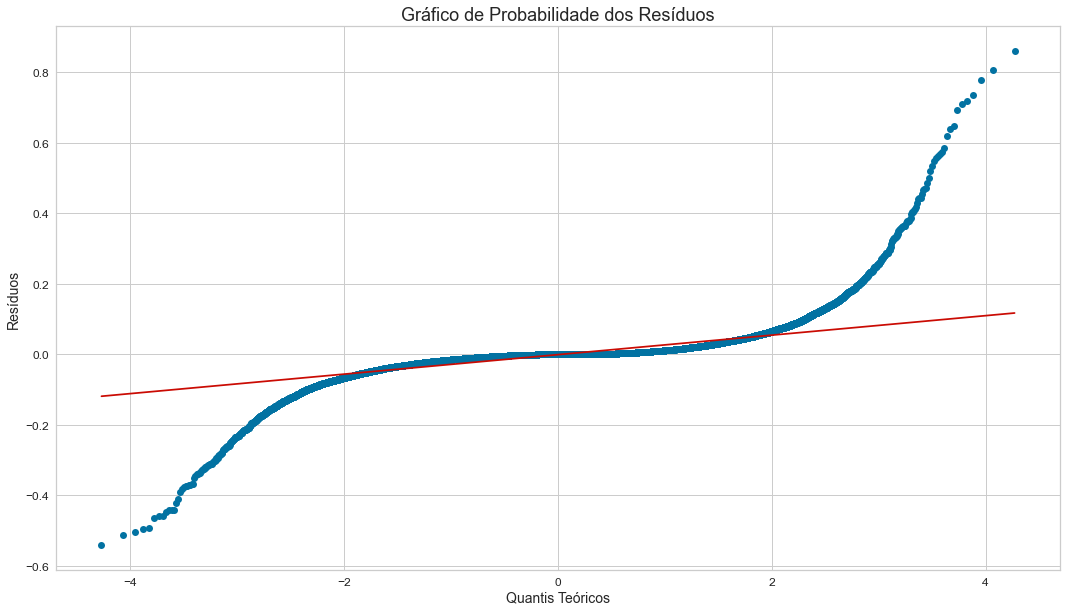

In [80]:
fig, ax = plt.subplots(figsize=(18,10))
_ = stats.probplot(resids, plot=ax)
plt.title('Gráfico de Probabilidade dos Resíduos', fontsize=18)
plt.xlabel('Quantis Teóricos', fontsize=14)
plt.ylabel('Resíduos', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [88]:
stats.kstest(resids, cdf='norm')

KstestResult(statistic=0.4530365141744999, pvalue=0.0)

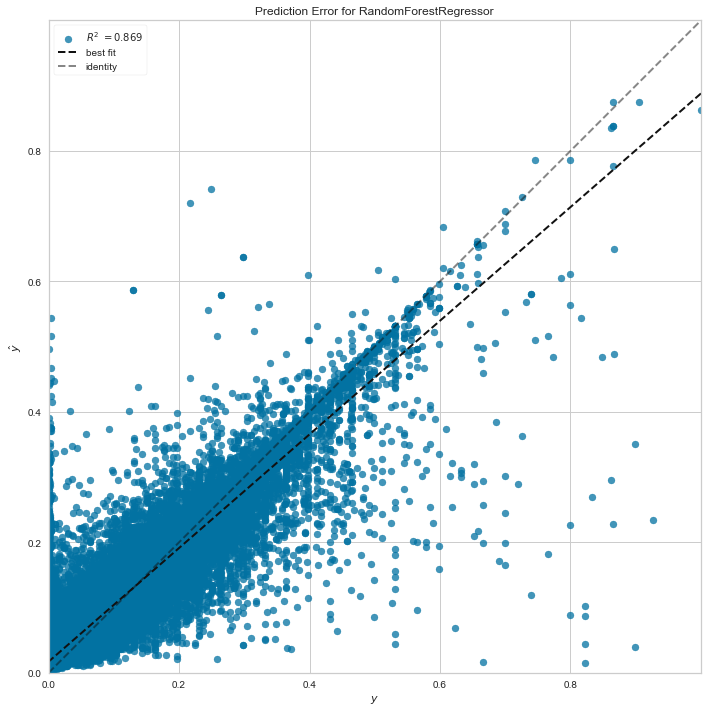

In [87]:
fig, ax = plt.subplots(figsize=(18,12))
pev = PredictionError(model)
pev.fit(x_train_preprocessed, y_train_preprocessed)
pev.score(x_test_preprocessed, y_test_preprocessed)
pev.poof()
plt.show()

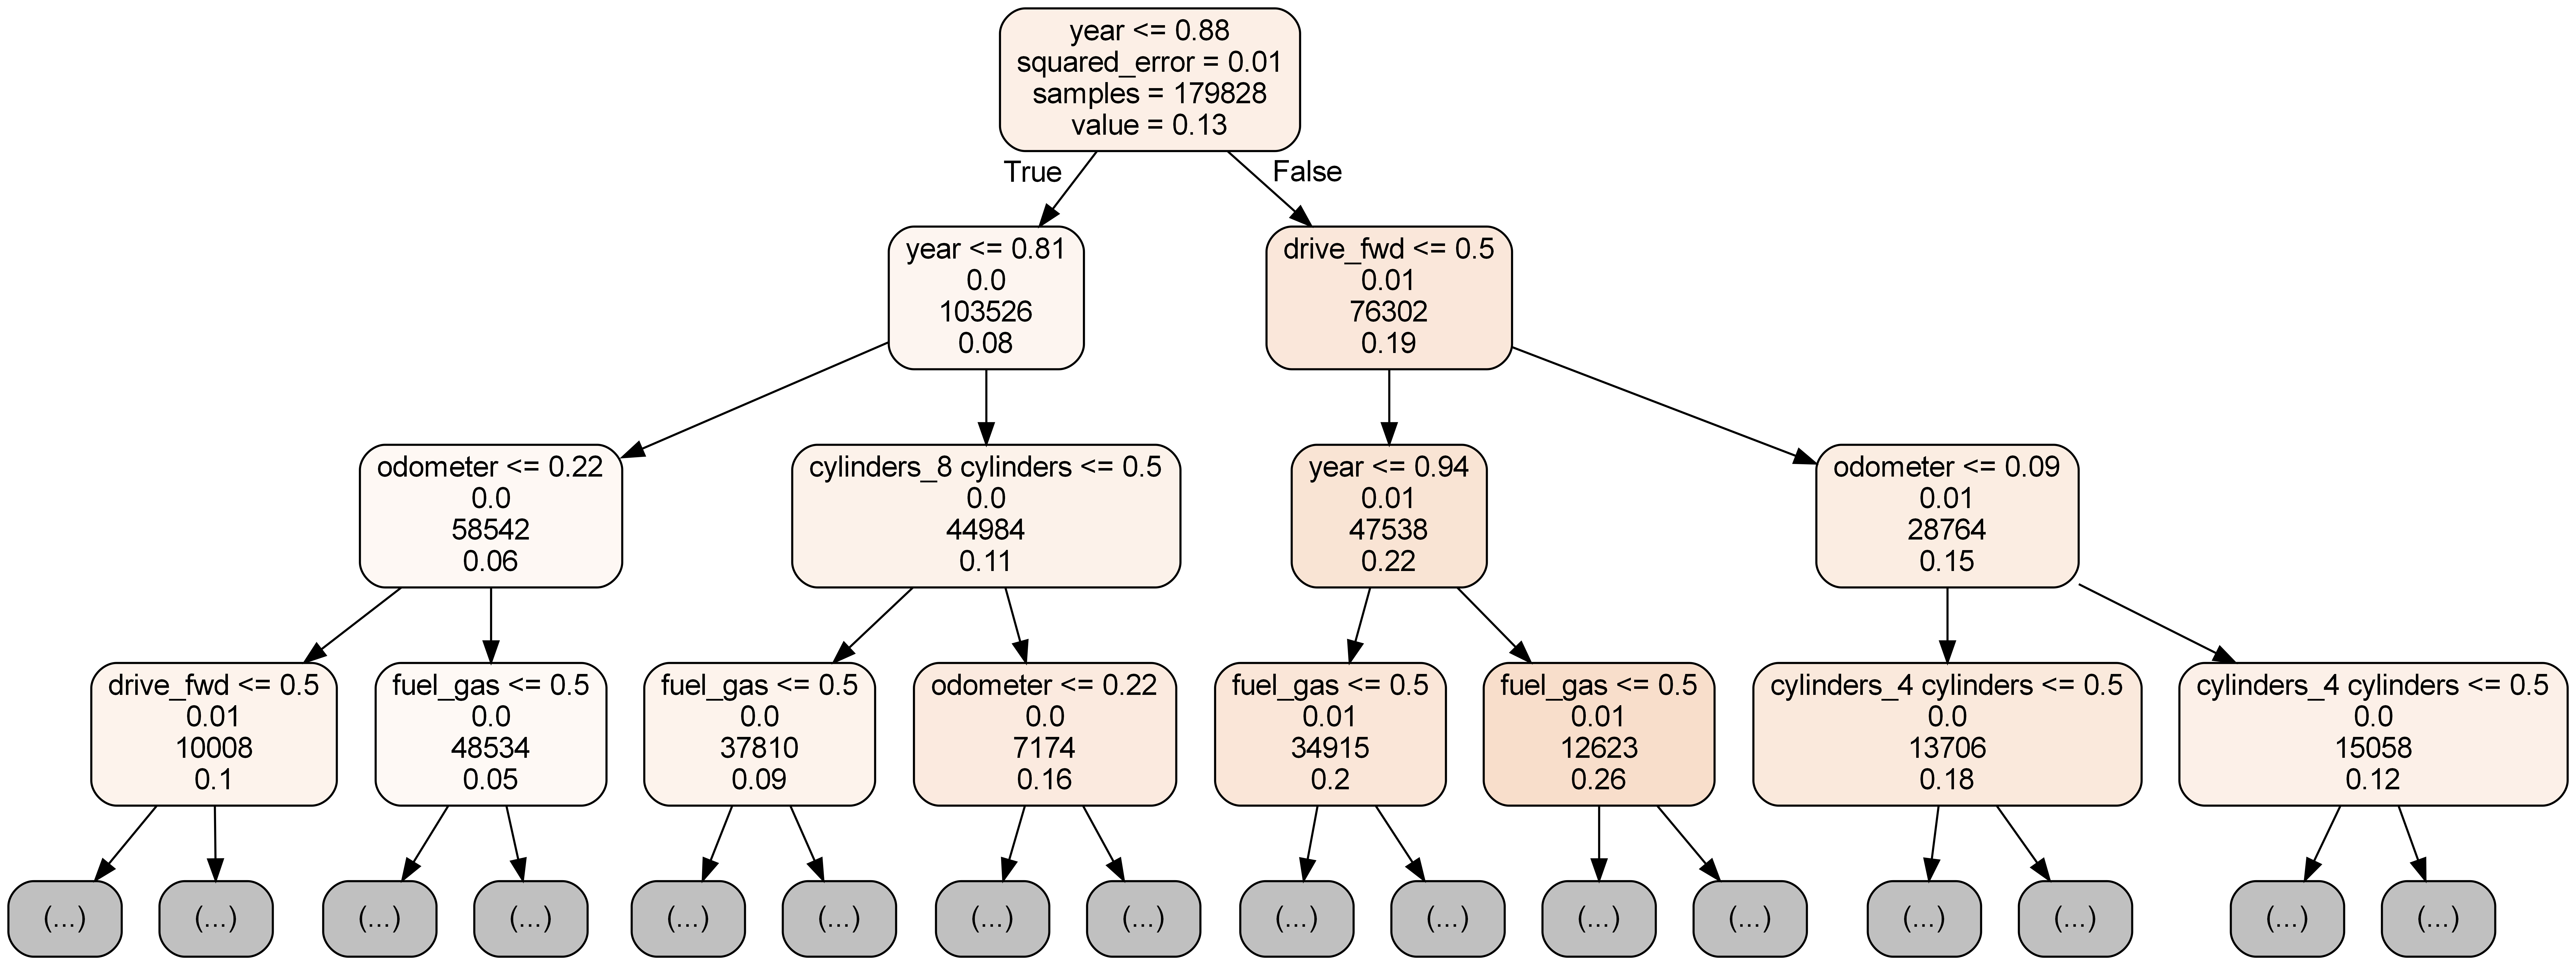

In [122]:
estimator = model.estimators_[5]
export_graphviz(estimator, out_file='tree.dot', 
                max_depth = 3,
                feature_names = x_train_preprocessed_df.columns,
                label= 'root',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
from IPython.display import Image
Image(filename = 'tree.png')

Gini importance (or mean decrease impurity), which is computed from the Random Forest structure. Let’s look how the Random Forest is constructed. It is a set of Decision Trees. Each Decision Tree is a set of internal nodes and leaves. In the internal node, the selected feature is used to make decision how to divide the data set into two separate sets with similars responses within. The features for internal nodes are selected with some criterion, which for classification tasks can be gini impurity or infomation gain, and for regression is variance reduction. We can measure how each feature decrease the impurity of the split (the feature with highest decrease is selected for internal node). For each feature we can collect how on average it decreases the impurity. The average over all trees in the forest is the measure of the feature importance. This method is available in scikit-learn implementation of the Random Forest (for both classifier and regressor). It is worth to mention, that in this method we should look at relative values of the computed importances. This biggest advantage of this method is a speed of computation - all needed values are computed during the Radom Forest training. The drawbacks of the method is to tendency to prefer (select as important) numerical features and categorical features with high cardinality. What is more, in the case of correlated features it can select one of the feature and neglect the importance of the second one (which can lead to wrong conclusions).

Text(0, 0.5, 'Feature')

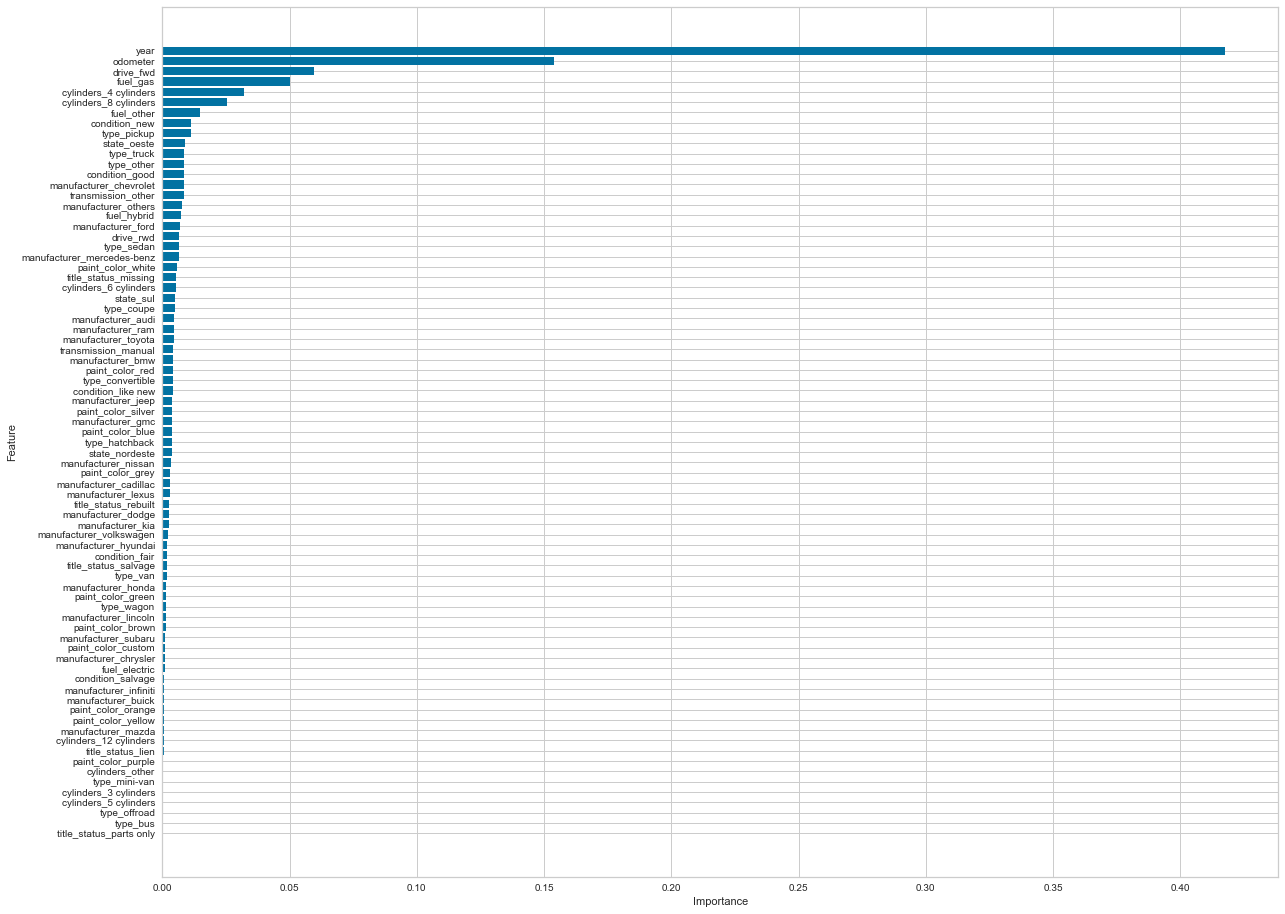

In [103]:
importances = model.feature_importances_
features = x_train_preprocessed_df.columns
indices = np.argsort(importances)[::1]
names = [features[i] for i in indices]
plt.figure(figsize=(20, 16))
plt.barh(range(x_train_preprocessed_df.shape[1]), importances[indices])
plt.yticks(range(x_train_preprocessed_df.shape[1]), names)
plt.xlabel('Importance')
plt.ylabel('Feature')



The permutation based importance can be used to overcome drawbacks of default feature importance computed with mean impurity decrease. It is implemented in scikit-learn as permutation_importance method. As arguments it requires trained model (can be any model compatible with scikit-learn API) and validation (test data). This method will randomly shuffle each feature and compute the change in the model’s performance. The features which impact the performance the most are the most important one.

In [123]:
perm_importance = permutation_importance(model, x_test_preprocessed, y_test_preprocessed)

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(x_train_preprocessed_df.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")


KeyboardInterrupt: 

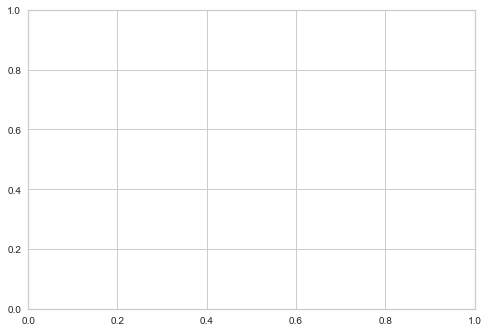

In [97]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
rfe = RFECV(RandomForestRegressor(n_estimators=100), cv=cv)
rfe.fit(x_train_preprocessed, y_train_preprocessed)


In [ ]:
rfe.rfe_estimator_.ranking_


In [ ]:
rfe.rfe_estimator_.n_features_

In [ ]:
rfe.rfe_estimator_.support_

In [ ]:
rfe.poof()

In [96]:
model_rf = RandomForestRegressor()
rfe_sk = RFE(model_rf, n_features_to_select=20)
rfe_sk.fit(x_train_preprocessed, y_train_preprocessed)
x_train_preprocessed_df.columns[rfe_sk.support_]


KeyboardInterrupt: 